# Accessing EDAV Data via Web Coverage Service

This example demonstrates how to retrieve raster data from EDAV using a Web Coverage Service (WCS). A WCS lets you access coverage data with multiple dimensions online. The downloaded data is subsetted from data hosted on the MAAP and is available with the full resolution and values.

## Setting up the Environment

We start by installing the libraries that are used to query the WCS connection point, and then to load, explore, and plot the raster data. We use `rasterio` for reading and writing raster formats, `rio-cogeo` for creating and validating Cloud Optimized GEOTIFF (COG) data, and `owslib` for interacting with Open Geospatial Consortium (OGC) services.

In [1]:
# install libraries 
# %pip is a magic command that installs into the current kernel
# -q means quiet (to give less output)
%pip install -q rasterio
%pip install -q rio-cogeo
%pip install -q owslib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


After installing the libraries, note that you may see multiple messages that you need to restart the kernel as seen in the above output. Then import `rasterio`, `show` from `rasterio.plot` to display images with labeled axes, and `WebCoverageService` from `owslib.wcs` to program with an OGC web service.

In [2]:
# import rasterio
import rasterio as rio
# import show
from rasterio.plot import show
# import WebCoverageService 
from owslib.wcs import WebCoverageService

## Querying the WCS

Now we can configure the WCS source, use the `getCoverage` function to request a file in GeoTIFF format, and save what is returned to our workspace.

In [3]:
# configure the WCS source
EDAV_WCS_Base = "https://edav-wcs.adamplatform.eu/wcs"
wcs = WebCoverageService(f'{EDAV_WCS_Base}?service=WCS', version='2.0.0')

In [4]:
# request imagery to download
response = wcs.getCoverage(
    identifier=['uavsar_AfriSAR_v1_SLC'], # coverage ID
    format='image/tiff', # format the coverage response will be returned as
    filter='false', # define constraints on query
    scale=1, # resampling factor (1 full resolution, 0.1 resolution degraded of a factor of 10)
    subsets=[('Long',11.6,11.7),('Lat',-0.2,-0.1)] # subset the image by lat / lon
)

# save the results to file as a tiff
results = "EDAV_example.tif"
with open(results, 'wb') as file:
    file.write(response.read())

We can use `gdalinfo` to provide information about our raster dataset to make sure the data is valid and contains spatial metadata.

In [5]:
# gives information about the dataset
!gdalinfo {results}

Driver: GTiff/GeoTIFF
Files: EDAV_example.tif
Size is 709, 709
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (11.599925815140329,-0.099890569280316)
Pixel Size = (0.000141205421952,-0.000141205421952)
Metadata:
  AREA_OR_POINT=Area
  OVR_RESAMPLING_ALG=BILINEAR
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  11.5999258,  -0.0998906) ( 11d35'59.73"E,  0d 5'59.61"S)
Lower Left  (  11.5999258,  -0.2000052) ( 11d35'59.73"E,  

## Reading the Data

We can now use `rio.open` with our `results` path string and return an opened dataset object. We can set a variable (`rast`) to what is read from this dataset object. Then, we utilize the function `show` to display the raster using Matplotlib.

In [6]:
# take path and return opened dataset object, set variable to read dataset object
with rio.open(results, 'r') as src:
        rast = src.read()

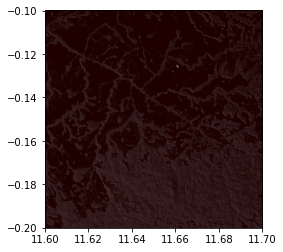

<AxesSubplot:>

In [7]:
# make a plot
show(rast, transform=src.transform, cmap='pink')#

We now have a visual of our raster, but it is a bit dark. To find out why, let's import and employ the `show_hist` function from `rasterio.plot` to generate a histogram of the raster.

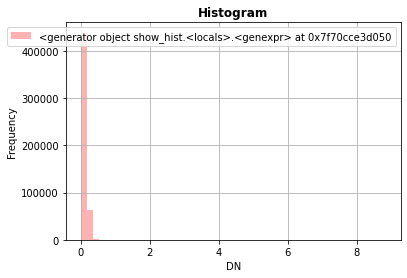

In [8]:
# import show_hist
from rasterio.plot import show_hist
# create histogram
show_hist(rast, 
          bins=50,# number of bins to compute histogram across
          alpha=.3,# transparancy 
          title="Histogram"# figure title
         )

The histogram shows a skewed distribution. The dark plot can be fixed by working directly with Matplotlib. Let's import `matplotlib.pyplot` and `numpy` and make a new plot. To do this, use the `plt.subplots` function to return a figure and a single "Axes" instance. Then remove single-dimensional entries from the shape of our array using `np.squeeze` and display the data as an image using `imshow`. Now, we can set the norm limits for image scaling using the `set_clim` function.

In [9]:
# import matplotlib.pyplot
import matplotlib.pyplot as plt
# import numpy
import numpy as np

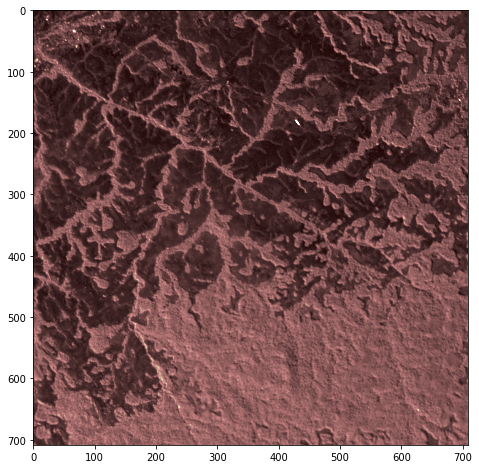

In [10]:
# set figure and single "Axes" instance
fig, ax = plt.subplots(1, figsize=(8,8))
# remove single-dimensional entries from the shape of the variable rast
#     and display the image
edavplot = ax.imshow(np.squeeze(rast), cmap='pink')
# set norm limits for image scaling
edavplot.set_clim(0,0.75)

## Newer Method `rioxarray`

Another way to work with raster data is with the `rasterio` "xarray" extension. Let's install and import `rioxarray` and create a plot using the `open_rasterio` and `plot` functions.

In [11]:
# install rasterio xarray extension
%pip install -q rioxarray

Note: you may need to restart the kernel to use updated packages.


In [12]:
# import rasterio xarray extension
import rioxarray

In [13]:
# opens results with rasterio to set dataarray
edav_x = rioxarray.open_rasterio(results)

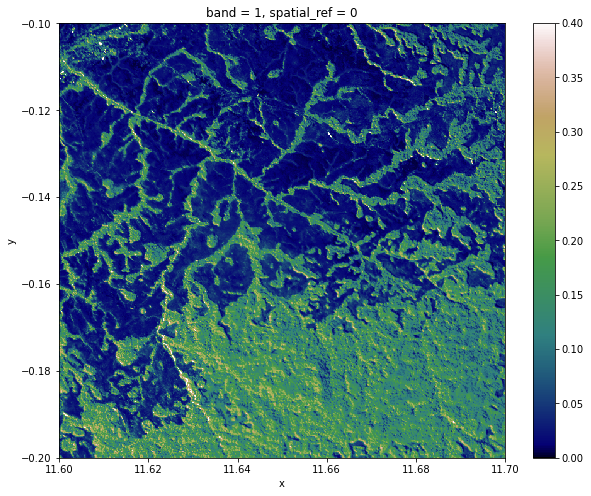

In [14]:
# plot dataarray
edav_x.plot(cmap="gist_earth", figsize=(10,8)).set_clim(0,0.4)

## References

* WCS Adapted from: Jan Verbesselt, Jorge Mendes de Jesus, Aldo Bergsma, Dainius Masiliūnas, David Swinkels, Corné Vreugdenhil. Handling Raster data with Python - 2020-01-20 https://geoscripting-wur.github.io/PythonRaster/
* OWSLib https://github.com/geopython/OWSLib
* rioxarray https://corteva.github.io/rioxarray



